In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import statsmodels.api as sm
from scipy import stats
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
themes = plt.style.available

This case study is based on the MIT [course](https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/case-studies/) Topics in Mathematics with Applications in Finance. 

In [3]:
print(themes)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Load the data: 

In [2]:
# rawData = pd.read_csv('rawData.csv')
# load the Clean data
cleanData = pd.read_csv('cleanData.csv').set_index('Date')

In [3]:
# Transform the date index into a datetime object.
cleanData.index = pd.to_datetime(cleanData.index,format='%Y-%m-%d')

In [4]:
cleanData.columns

Index(['DGS3MO', 'DGS1', 'DGS5', 'DGS10', 'DAAA', 'DBAA', 'DCOILWTICO', 'GE',
       'BAC', 'XOM', 'S&P'],
      dtype='object')

In [5]:
fredData = cleanData[['DGS3MO','DGS1','DGS5','DGS10','DAAA','DBAA','DCOILWTICO']]

In [6]:
fredData

,DGS3MO,DGS1,DGS5,DGS10,DAAA,DBAA,DCOILWTICO
Date,,,,,,,
2000-01-03,5.48,6.09,6.50,6.58,7.75,8.27,NaN
2000-01-04,5.43,6.00,6.40,6.49,7.69,8.21,25.56
2000-01-05,5.44,6.05,6.51,6.62,7.78,8.29,24.65
2000-01-06,5.41,6.03,6.46,6.57,7.72,8.24,24.79
2000-01-07,5.38,6.00,6.42,6.52,7.69,8.22,24.79
...,...,...,...,...,...,...,...
2013-05-24,0.04,0.12,0.90,2.01,3.94,4.76,93.84
2013-05-28,0.05,0.13,1.02,2.15,4.06,4.88,94.65
2013-05-29,0.05,0.14,1.02,2.13,4.04,4.88,93.13


In [7]:
stockData = cleanData[ ['GE','BAC', 'XOM', 'S&P']]
stockData

,GE,BAC,XOM,S&P
Date,,,,
2000-01-03,26.605433,14.021359,20.760025,1455.219971
2000-01-04,25.541218,13.189125,20.362385,1399.420044
2000-01-05,25.496870,13.333860,21.472454,1402.109985
2000-01-06,25.837751,14.473662,22.582546,1403.449951
2000-01-07,26.838230,14.093729,22.516262,1441.469971
...,...,...,...,...
2013-05-24,18.647718,11.744439,65.902351,1649.599976
2013-05-28,18.703194,11.842014,66.514366,1660.060059
2013-05-29,18.734898,11.957328,66.298370,1648.359985


In [8]:
# Compute log daily log Returns ( we remove the first one)
# Marlon: renamed df to conform to naming convention
dailyStockReturns = np.log(stockData).diff()[1:]

In [9]:
dailyStockReturns

,GE,BAC,XOM,S&P
Date,,,,
2000-01-04,-0.040822,-0.061189,-0.019340,-0.039099
2000-01-05,-0.001738,0.010914,0.053082,0.001920
2000-01-06,0.013281,0.082024,0.050406,0.000955
2000-01-07,0.037991,-0.026601,-0.002940,0.026730
2000-01-10,-0.000413,-0.035275,-0.014079,0.011128
...,...,...,...,...
2013-05-24,-0.005510,0.002269,-0.002837,-0.000552
2013-05-28,0.002970,0.008274,0.009244,0.006321
2013-05-29,0.001694,0.009691,-0.003253,-0.007073


In [10]:
# Compute daily return of the risk-free asset 
#     accounting for the number of days between successive closing prices
#     apply annual interest rate using 360 days/year (standard on 360-day yearsince the previous close)
diffDays = np.array([(cleanData['DGS3MO'].index[i+1] - cleanData['DGS3MO'].index[i]
                    ).days for i in range(len(cleanData['DGS3MO'])-1 )])

dailyRiskFree = np.log(1+ 0.01*cleanData['DGS3MO'][1:]*diffDays/360
                      ).rename('Risk free')

In [11]:
dailyRiskFree

Date
2000-01-04    0.000151
2000-01-05    0.000151
2000-01-06    0.000150
2000-01-07    0.000149
2000-01-10    0.000452
                ...   
2013-05-24    0.000001
2013-05-28    0.000006
2013-05-29    0.000001
2013-05-30    0.000001
2013-05-31    0.000001
Name: Risk free, Length: 3372, dtype: float64

In [12]:
dailyGEFree = (dailyStockReturns['GE'] - dailyRiskFree).rename('GE.free')
dailySNPFree = (dailyStockReturns['S&P'] - dailyRiskFree).rename('S&P.free')

In [13]:
pd.concat([dailyStockReturns[['GE','S&P']],
           dailyRiskFree,
           dailyGEFree,
           dailySNPFree],axis=1)

,GE,S&P,Risk free,GE.free,S&P.free
Date,,,,,
2000-01-04,-0.040822,-0.039099,0.000151,-0.040973,-0.039250
2000-01-05,-0.001738,0.001920,0.000151,-0.001889,0.001769
2000-01-06,0.013281,0.000955,0.000150,0.013131,0.000805
2000-01-07,0.037991,0.026730,0.000149,0.037841,0.026581
2000-01-10,-0.000413,0.011128,0.000452,-0.000865,0.010676
...,...,...,...,...,...
2013-05-24,-0.005510,-0.000552,0.000001,-0.005511,-0.000553
2013-05-28,0.002970,0.006321,0.000006,0.002965,0.006315
2013-05-29,0.001694,-0.007073,0.000001,0.001692,-0.007074


In [14]:
dailySNPFree[dailySNPFree<0]

Date
2000-01-04   -0.039250
2000-01-11   -0.013299
2000-01-12   -0.004547
2000-01-18   -0.007473
2000-01-20   -0.007273
                ...   
2013-05-22   -0.008309
2013-05-23   -0.002930
2013-05-24   -0.000553
2013-05-29   -0.007074
2013-05-31   -0.014412
Name: S&P.free, Length: 1597, dtype: float64

In [15]:
# Playing with the sns plot: 

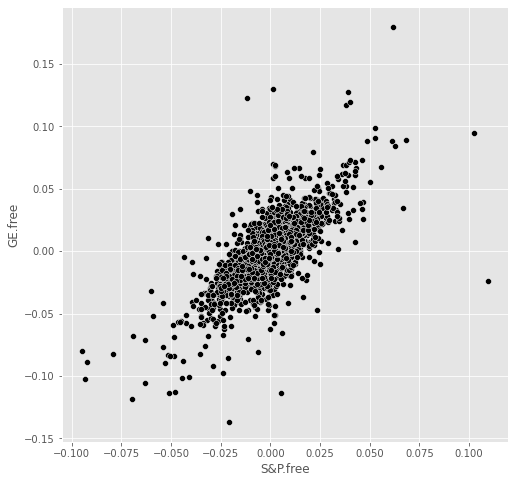

In [16]:
plt.figure(figsize=(8,8))
# Marlon: adding a semi-colon at the end of a plot statement prevents matplotlib from
# printing the object's location in memory. 
sns.scatterplot(y = dailyGEFree,
                x = dailySNPFree,
                color='black'
               );

In [17]:
# Marlon: this seems unnecessary
# plt.figure(figsize=(8,8))
# sns.lineplot(x=GE_daily_free,y= 0.4*GE_daily_free,color='green',label='y=0.4x+1')
# sns.scatterplot(x=GE_daily_free,y=SNP_daily_free,color='black',legend='')
# sns.scatterplot(x = GE_daily_free[GE_daily_free<0],y=SNP_daily_free[SNP_daily_free<0],color='red',label='red')
# sns.scatterplot(x = GE_daily_free[GE_daily_free<0],y=SNP_daily_free[SNP_daily_free>0.1],color='blue',label='blue')

In [18]:
#################################################################################################################################### 
# FITTING A LINEAR REGRESSION USING STATS MODELS ( For Marlon)
###################################################################################################################################

Stats Models [documentations](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html).

# CAPM 
 Sharpe (1964) and Lintner (1965) developed the Capital Asset Pricing Model for a market in which investors have the same expectations, hold portfolios of risky assets that are mean-variance efficient, and can borrow and lend money freely at the same risk-free rate.
 The expected return of asset j is : 

 $$ E[R_j] = R_{riskfree} + \beta_j (E[R_{market}] - R_{riskfree} ) $$  where $$\beta_j   = \frac{Cov(R_j,Risk_{market})}{Var(R_{market})}$$
 
 where $R_{Market}$ is the return on the market portfolio and $R_{riskfree}$ is the return on the risk-free asset. 
 Consider fitting the simple linear regression model of a stock’s daily excess return on the market-portfolio daily excess return, using the S&P 500 Index as the proxy for the market return and the 3-month Treasury constant maturity rate as the risk-free rate. The linear model is given by: 
 
 $$ R^{*}_{j,t}  = \alpha_j + \beta_j R^{*}_{market,t} + \epsilon_{j,t} $$ where $$\epsilon_{j,t}  $$ are gaussian white noise.

 Under the assumptions of the CAPM, the regression parameters $(\alpha_j , \beta_j )$ are such that $\beta_j$ is the same as in the CAPM model, and $\alpha_j$ is zero

In [19]:
# Marlon: fixed incorrect order of x and y
x , y = np.array(dailySNPFree), np.array(dailyGEFree)
x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()

In [20]:
# This is printed in the results summary below and is unnecessary. 
# Move it to the plot of regression line below. 
results.params

array([-1.32562916e-04,  1.18439846e+00])

In [21]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     4432.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:32:37   Log-Likelihood:                 9659.1
No. Observations:                3372   AIC:                        -1.931e+04
Df Residuals:                    3370   BIC:                        -1.930e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.558      0.5

The t-statistic for the intercept is non-significant at a 95% confidence level, so we fail to reject the null hypothesis that $\alpha$ = 0.

### Regression diagnostics

We will diagnose the regression fit based on two measures:
* an analysis of variance (ANOVA), detailing the computation of the F-statistic for no regression structure
* a study of influcence measures, evaluation case influence for the linear regression model;

<AxesSubplot:xlabel='S&P.free', ylabel='GE.free'>

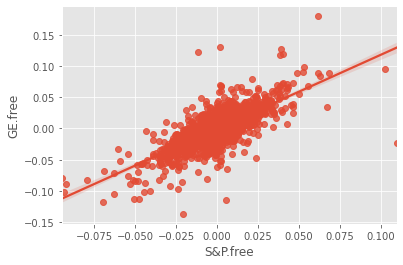

In [22]:
# The chosen theme does not print a good model on reg plot
sns.regplot(x = dailySNPFree, y = dailyGEFree)

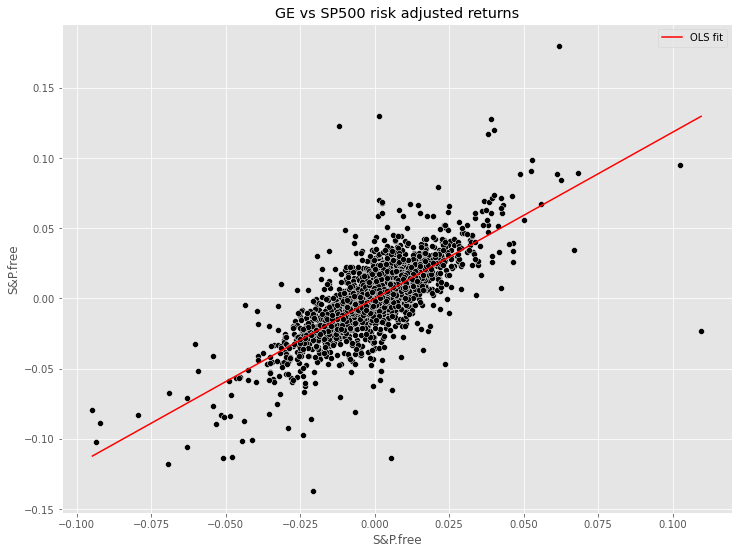

In [23]:
alpha, beta = results.params
plt.figure(figsize = (12,9))
sns.lineplot(x = dailySNPFree,
             y = alpha + beta*dailySNPFree,
             color = 'red',
             label = 'OLS fit'
            )
sns.scatterplot(y = dailyGEFree,
                x = dailySNPFree,
                color='black'
               );
plt.title('GE vs SP500 risk adjusted returns');

In [24]:
# sm.stats.anova_lm(results,typ=2)

In [25]:
# sm.stats.anova_lm?

#### Influence measures

influence = results.get_influence()
influenceDf = influence.summary_frame()
influenceDf.index = dailySNPFree.index
influenceDf

Let $H = X(X^{T}X)^{-1}X^{T}$ denote the projection matrix of the least squares model. The leverage score for the i-th observation is defined as $h_{i} = H_{ii}$. These elements are listed in the hat_diag column of the influence dataframe. Below we plot their time-series. 

A point is considered high-leveraged if its leverage is above 
$$ \frac{(2p+2)}{n}$$

In [26]:
leverage_threshold = (2*2+2)/len(dailyGEFree)
influenceDf['high leverage'] = (influenceDf['hat_diag']> leverage_threshold)
influenceDf

NameError: name 'influenceDf' is not defined

In [ ]:
plt.figure(figsize = (12,9))
sns.lineplot(x = dailySNPFree.index,
             y = leverage_threshold,
             color = 'red',
             dashes = True,
             label = 'High leverage'
            )
sns.lineplot(y = influenceDf['hat_diag'],
                x = dailySNPFree.index,
                color = 'black')
plt.title("Risk adjuted GE vs SNP")
plt.ylabel("Leverage scores")
plt.legend();

<a href = "https://en.wikipedia.org/wiki/Cook%27s_distance" target = "_blank"> Cook's distance</a> is a measure of influence accounting for the effect of deleting a given observation. 

Consider a regression model 
$$ y = X\beta + \epsilon,$$
where 
* $y$ is an $n \times 1$ response vector;
* $X$ is an $n \times p$ design matrix;
* $\beta$ is a $p \times 1$ coefficient matrix; 
* $\epsilon$ is a random vector distributed as $\epsilon \sim N(0, \sigma^2 I_n)$.

Let $H = X(X^{T}X)^{-1}X^{T}$ be the projection matrix as above, $\mathbf{y}$ the observed values of a dependent random variable, $\widehat{\mathbf{y}}$ the predicted values, $\widehat{\mathbf{y}} = H\mathbf{y}$, and denote by $\mathbf{e} = (I-H)\mathbf{y}$ the residual vector. We also denote by $\widehat{\mathbf{y}}_{i}$ the fitted response variable when the $i$-th observation is removed from the dataset. Then we define Cook's distance as 
$$D_i = \frac{\| \widehat{\mathbf{y}} - \widehat{\mathbf{y}}_{i}\|^{2}}{p*\mathrm{MSE}},$$
where $\| \cdot \|$ is the l^2 norm, $p$ is the number of coefficients in the regression, and $\mathrm{MSE}$ stands for the mean squared error:
$$ \mathrm{MSE} = \frac{\|e\|^2}{n-p}.$$
We define an observation as influential relative to Cook's distance if its distance is at least the median point of an <a href = "https://en.wikipedia.org/wiki/F-distribution" target = "_blank">$F$-distribution </a> with $(p,n-p)$ degrees of freedom.

In [ ]:
cooks_threshold = stats.f.ppf(0.5, 2, len(dailyGEFree) - 2)
influenceDf['high cooks distance'] = (influenceDf['cooks_d'] > cooks_threshold)
plt.figure(figsize = (12,9))
sns.lineplot(x = dailySNPFree.index,
             y = cooks_threshold,
             color = 'red',
             dashes = True,
             label = "Cook's threshold"
            )
sns.lineplot(y = influenceDf['cooks_d'],
                x = dailySNPFree.index,
                color = 'black');
plt.ylabel("Cook's distances")
plt.title("Risk adjuted GE vs SNP")
plt.legend();

In [ ]:
plt.figure(figsize = (12,9))
sns.lineplot(x = dailySNPFree,
             y = alpha + beta*dailySNPFree,
             color = 'green',
             label = 'OLS fit'
            )
sns.scatterplot(y = dailyGEFree,
                x = dailySNPFree,
                hue = influenceDf['high leverage'],
                style = influenceDf['high cooks distance']
               );

plt.title('GE vs SP500 risk adjusted returns');

In [33]:
len(dailyGEFree)

3372

In [36]:
stats.f.ppf(0.5, 2, len(dailyGEFree) - 2)

0.693289767772602

#### 